In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pandas as pd

In [16]:
def exp_model(x, a, b, lambda_):
    return a - b*np.exp(-lambda_*x)

In [17]:
# Define the parameters
n_students = 1000
a = 0.8
b = 0.3
lambda_ = 0.1
scale_param = 60


def dummy_data_generator(n_students, a, b, lambda_, scale_param):
    # Initialize the random number generator
    np.random.seed(24)

    # Generate dummy student data 
    proba_dataset = pd.DataFrame({'user_id': [], 'attempt': [], 'correct_predictions': []})
    max_attempt = (np.rint(np.random.exponential(scale_param, n_students))).astype(int) # We saw that the number of attempts per student is exponentially distributed
    for i in range(len(max_attempt)):
        user_id = np.repeat(i, max_attempt[i]) 
        attempt = np.arange(max_attempt[i])
        e = np.random.randn(max_attempt[i])*(np.random.randn()*0.1 + 0.1) # Generate some noise with a different variance for each student
        correct_predictions = exp_model(attempt, a, b, lambda_) + e # Generate the probability of success for each attempt
        
        proba_dataset = pd.concat([proba_dataset, pd.DataFrame({'user_id': user_id, 'attempt': attempt, 'correct_predictions': correct_predictions})], ignore_index=True)
        
    return proba_dataset

proba_dataset = dummy_data_generator(n_students, a, b, lambda_, scale_param)
display(proba_dataset)

,user_id,attempt,correct_predictions
0,0.0,0.0,0.281769
1,0.0,1.0,0.758221
2,0.0,2.0,0.402396
3,0.0,3.0,0.373244
4,0.0,4.0,0.763534
...,...,...,...
63981,999.0,2.0,0.482680
63982,999.0,3.0,0.559929
63983,999.0,4.0,0.595931
63984,999.0,5.0,0.586914


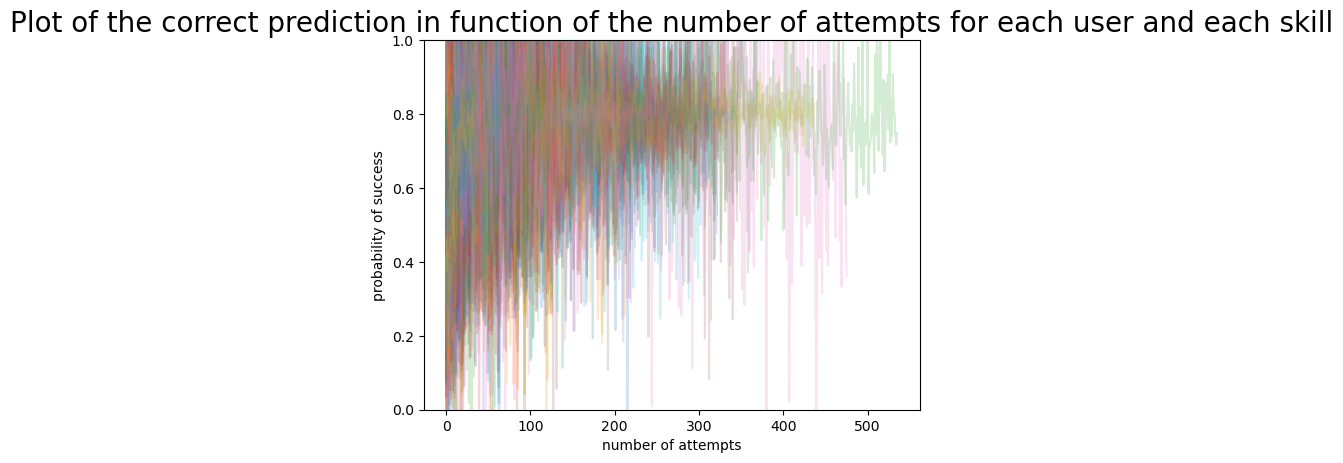

In [18]:
df = proba_dataset.set_index('attempt', inplace=False)
df.groupby('user_id')['correct_predictions'].plot(alpha=0.2, legend=False)
plt.xlabel('number of attempts')
plt.ylabel('probability of success')
plt.title('Plot of the correct prediction in function of the number of attempts for each user and each skill', fontsize=20)
plt.ylim(0, 1)
plt.show()

In [19]:
def exp_fit(x):
    param_pred, cov_pred = scipy.optimize.curve_fit(lambda t,a,b,lambda_: a-b*np.exp(-lambda_*t),  x.attempt,  x.correct_predictions, bounds=([0,-1,0], [1, 1, np.inf]))
    a, b, lambda_ = param_pred
    return pd.Series([a, b, lambda_], index=['a', 'b', 'lambda_'])

/Users/emmaboehly/programmation/anaconda3/envs/MLBD/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


parameters for the exponential fit for each student


,a,b,lambda_,number_attempts
user_id,,,,
0.0,0.832808,0.384812,0.066845,193
1.0,0.797428,0.302640,0.101759,72
2.0,0.795849,0.410156,0.132909,536
3.0,1.000000,0.625089,0.116378,15
4.0,0.814980,0.526212,0.204884,27
...,...,...,...,...
995.0,1.000000,0.510933,0.050582,4
996.0,0.809862,0.306679,0.091491,46
997.0,0.746734,0.176134,0.145678,24


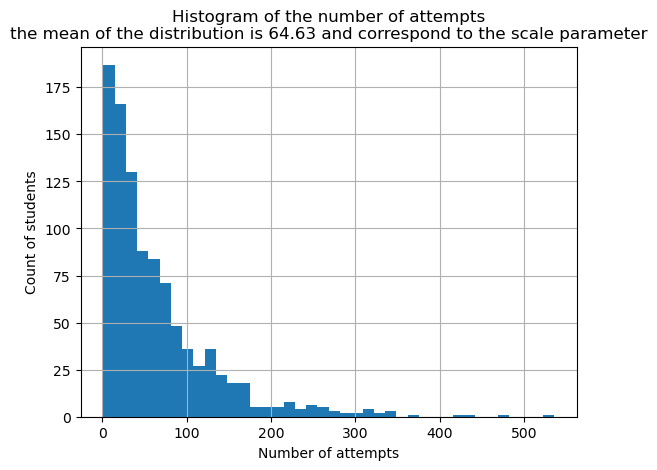

In [20]:
# Compute the parameters for the exponential fit for each student
students_param = proba_dataset.groupby('user_id').apply(lambda x: exp_fit(x))
students_param['number_attempts'] = proba_dataset.groupby('user_id').size()
print('parameters for the exponential fit for each student')
display(students_param)

# Plot the histogram of the number of attempts
students_param.number_attempts.hist(bins=40)
plt.title('Histogram of the number of attempts\nthe mean of the distribution is {:.2f} and correspond to the scale parameter'.format(students_param.number_attempts.mean()))
plt.xlabel('Number of attempts')
plt.ylabel('Count of students')
plt.show()

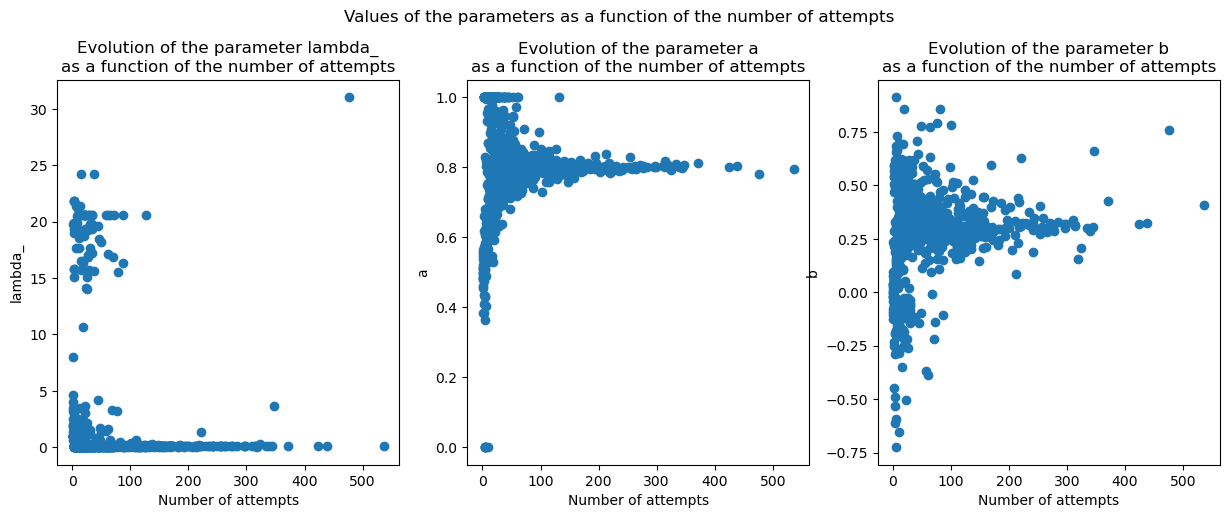

There is 230 students with more than 90 attempts which corresponds to 23.23 % of the students


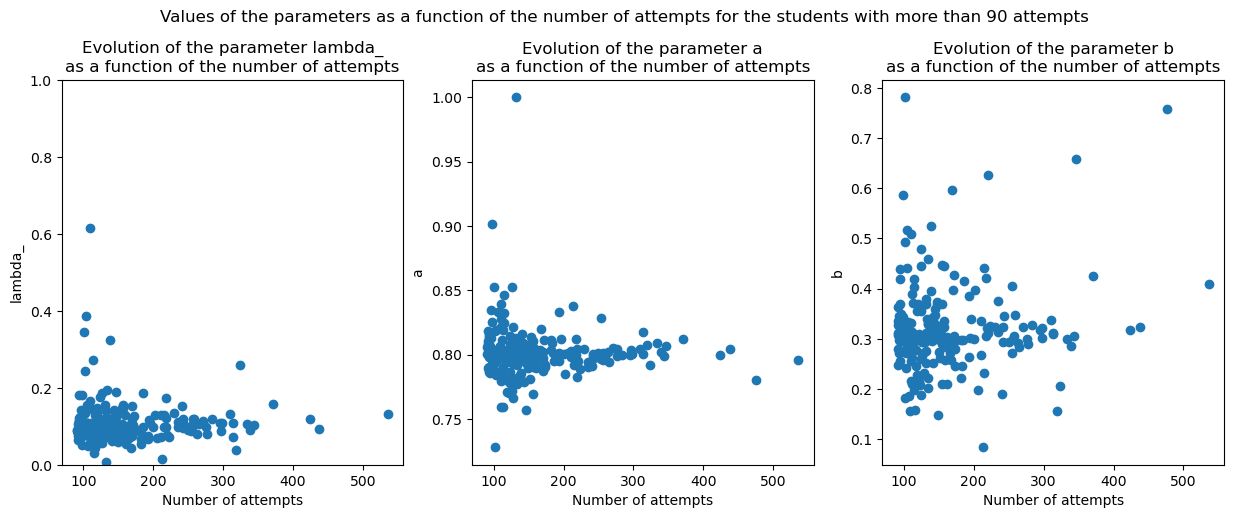

In [21]:
# Plot the values of each parameter as a function of the number of attempts
parameters = ['lambda_', 'a', 'b']

# Keep only the students that played the most, i.e. that are more likely to have reached their maximum performance
min_attempts = 1.2*scale_param
master_param = students_param[students_param['number_attempts'] > min_attempts]
print('There is', master_param.shape[0], 'students with more than', int(min_attempts), 'attempts which corresponds to', round(master_param.shape[0]/students_param.shape[0]*100, 2), '% of the students')

# Plot the fitted parameters as a function of the number of attempts
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
for i, param in enumerate(parameters):
    ax[i].plot(students_param['number_attempts'], students_param[param], 'o')
    ax[i].set_xlabel('Number of attempts')
    ax[i].set_ylabel(param)
    ax[i].set_title('Evolution of the parameter ' + param + '\nas a function of the number of attempts')
    ax[i].axvline(min_attempts, color='red', linestyle='--')
plt.suptitle('Values of the parameters as a function of the number of attempts', y=1.02)
plt.show()

In [22]:
# Extract the median value of each parameter
a_pred, b_pred, lambda_pred,_ = master_param.median()
print('The median values of the parameters are:')
print('a =', a_pred)
print('b =', b_pred)
print('lambda =', lambda_pred)

The median values of the parameters are:
a = 0.8000804541678455
b = 0.30259658972363757
lambda = 0.10052514980771847


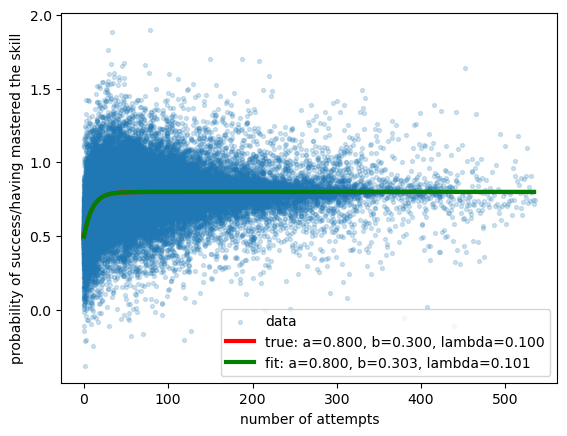

In [23]:
rx = np.arange(max(proba_dataset.attempt))

plt.scatter(proba_dataset.attempt, proba_dataset.correct_predictions, label='data', alpha=0.2, s=8)
plt.plot(rx, exp_model(rx, a, b, lambda_), label='true: a=%5.3f, b=%5.3f, lambda=%5.3f' % tuple([a,b,lambda_]), color='red', linewidth=3)
plt.plot(rx, exp_model(rx, a_pred, b_pred, lambda_pred), label='fit: a=%5.3f, b=%5.3f, lambda=%5.3f' % tuple([a_pred, b_pred, lambda_pred]), color='green', linewidth=3)
plt.xlabel('number of attempts')
plt.ylabel('probability of success/having mastered the skill')
plt.legend()
plt.show()

# Predict the number of attempt

In [24]:
# Define which probability of success is considered as mastered
proba_mastering = 0.955*a_pred
tot_attempt_mastering = np.ceil((-1/lambda_pred)*np.log((a_pred - proba_mastering)/b_pred)).astype(int)
print('The probability of success considered as mastered is', round(proba_mastering, 3))
print('We consider that a student has mastered the skill if the probability of success is higher than 95.5% of the maximum probability of success')
print('The expected number of attempts to reach this probability of success is', tot_attempt_mastering, 'attempts, for a student that has not begun to learn the skill yet')

The probability of success considered as mastered is 0.764
We consider that a student has mastered the skill if the probability of success is higher than 95.5% of the maximum probability of success
The expected number of attempts to reach this probability of success is 22 attempts, for a student that has not begun to learn the skill yet


In [25]:
def attempt_from_proba(proba, a_pred, b_pred, lambda_pred, confidence = 0.955):
    proba_mastering = confidence*a_pred
    if proba > proba_mastering:
        return 0
    else:
        tot_attempt = np.ceil((-1/lambda_pred)*np.log((a_pred - proba_mastering)/b_pred)).astype(int)
        equivalent_attempt = np.ceil((-1/lambda_pred)*np.log((a_pred - proba)/b_pred)).astype(int)
        return tot_attempt - equivalent_attempt

In [26]:
# Generate data for new students (we already computed the probability of success for the last attempt)
n_students = 800
proba_test = dummy_data_generator(n_students, a, b, lambda_, scale_param)

To test our model and predict the number of attempts needed to master a skill, we generate another dataset using the same distribution parameters than the training dataset. <br>
To make prediction, we (theoretically) only need the probability for the last attempt (which summarise all the data we have for a student until now). <br>
However, as we want to compare our predictions with the real number of attempts, we will use a previous attempt as 'fake' last attempt and predict the number of attempts needed to master the skill from this fake last attempt.

In [73]:
# Extract the correct prediction for the 3rd attempt for each student (if it exists)
third_proba = proba_test[proba_test['attempt'] == 3].rename(columns={'correct_predictions': 'third_proba'}).drop(columns=['attempt'])

# Extract the first attempt number from which the student has actually mastered the skill (this is done by computing a moving average on the correct predictions beforehand)
mastering_attempt = pd.DataFrame()
window_sizes = np.arange(1, 7)
for window in window_sizes:
    moving_average = proba_test.groupby('user_id').rolling(window, on='attempt', min_periods=1)['correct_predictions'].mean().reset_index()
    mastering_attempt['true_attempt_avg' + str(window)] = (moving_average[moving_average['correct_predictions'] >= proba_mastering]).groupby('user_id')['attempt'].first()

# Merge de 2 dataframes and keep only the students that have both a 3rd attempt and a mastered the skill
test_dataset = pd.merge(third_proba, mastering_attempt, on='user_id', how='inner')
    
test_dataset

,user_id,third_proba,true_attempt_avg1,true_attempt_avg2,true_attempt_avg3,true_attempt_avg4,true_attempt_avg5,true_attempt_avg6
0,0.0,0.678285,5.0,6.0,14.0,16.0,17.0,17.0
1,1.0,0.577557,22.0,22.0,23.0,23.0,24.0,24.0
2,2.0,0.655647,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.571647,9.0,10.0,NaN,12.0,NaN,NaN
4,4.0,0.711275,16.0,16.0,17.0,19.0,19.0,20.0
...,...,...,...,...,...,...,...,...
679,795.0,0.632282,5.0,11.0,13.0,22.0,23.0,24.0
680,796.0,0.528244,11.0,15.0,16.0,16.0,17.0,16.0
681,797.0,0.613123,19.0,20.0,20.0,22.0,26.0,27.0
682,798.0,0.352561,5.0,13.0,23.0,24.0,24.0,31.0


In [74]:
# Predict the number of attempts needed to master the skill
test_dataset['predicted_attempts'] = test_dataset.third_proba.apply(lambda x: attempt_from_proba(x, a_pred, b_pred, lambda_pred))
print(proba_mastering)
test_dataset


0.7640768337302923


,user_id,third_proba,true_attempt_avg1,true_attempt_avg2,true_attempt_avg3,true_attempt_avg4,true_attempt_avg5,true_attempt_avg6,predicted_attempts
0,0.0,0.678285,5.0,6.0,14.0,16.0,17.0,17.0,12
1,1.0,0.577557,22.0,22.0,23.0,23.0,24.0,24.0,18
2,2.0,0.655647,0.0,0.0,0.0,0.0,0.0,0.0,14
3,3.0,0.571647,9.0,10.0,NaN,12.0,NaN,NaN,19
4,4.0,0.711275,16.0,16.0,17.0,19.0,19.0,20.0,9
...,...,...,...,...,...,...,...,...,...
679,795.0,0.632282,5.0,11.0,13.0,22.0,23.0,24.0,16
680,796.0,0.528244,11.0,15.0,16.0,16.0,17.0,16.0,20
681,797.0,0.613123,19.0,20.0,20.0,22.0,26.0,27.0,17
682,798.0,0.352561,5.0,13.0,23.0,24.0,24.0,31.0,25


# Evaluate the model

In [82]:
# Compute the Mean Absolute Error
mae = pd.DataFrame(index=window_sizes)
for window in window_sizes:
    mae.loc[window, 'mae'] = np.mean(np.abs(test_dataset['true_attempt_avg' + str(window)] - test_dataset.predicted_attempts))
display(mae)

# Find the best window size
best_window = mae.idxmin()[0]

,mae
1,9.086257
2,7.664122
3,7.199683
4,7.123596
5,7.311558
6,7.582624


,true,predicted
count,623.000000,684.000000
mean,16.176565,17.296784
std,6.820927,6.608565
min,0.000000,0.000000
25%,12.000000,15.000000
50%,17.000000,18.000000
75%,21.000000,21.000000
max,33.000000,34.000000


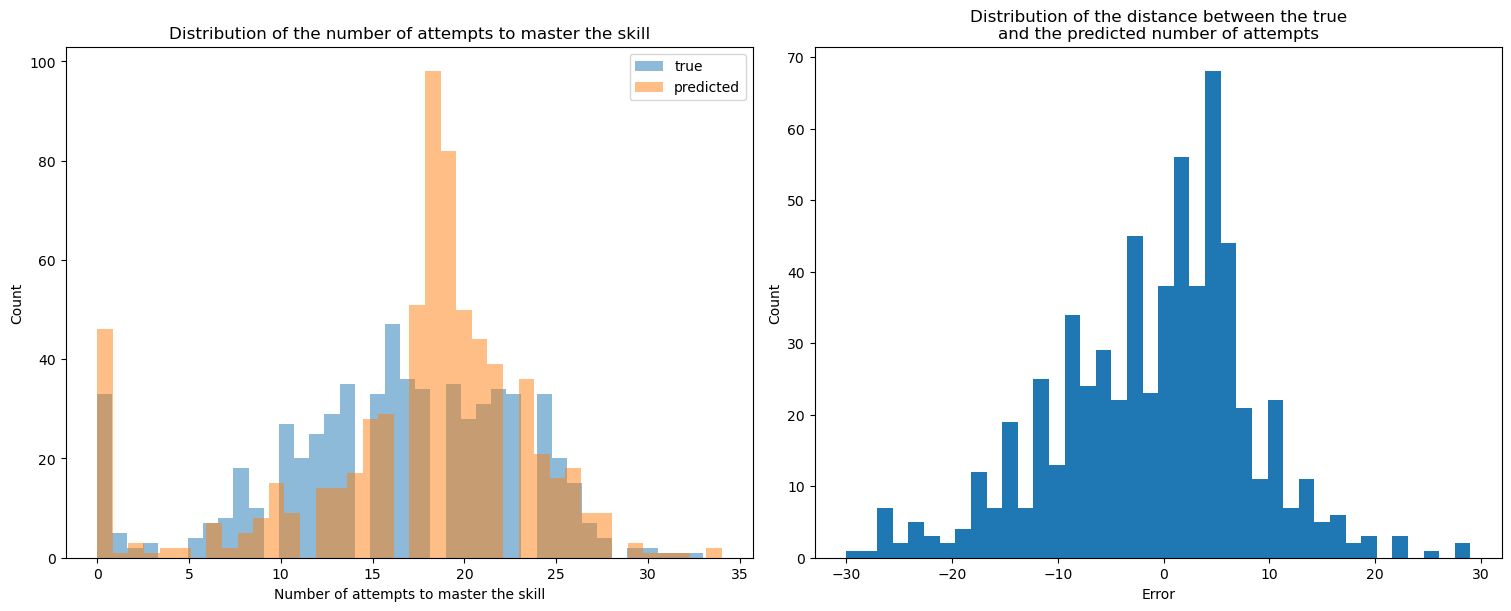

In [83]:
# Results for the best window size
describe_df = pd.DataFrame()
describe_df['true'] = test_dataset['true_attempt_avg' + str(best_window)].describe()
describe_df['predicted'] = test_dataset.predicted_attempts.describe()
display(describe_df)

fig, ax = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
# Plot both distributions
ax[0].hist(test_dataset['true_attempt_avg' + str(best_window)], bins=40, alpha=0.5, label='true')
ax[0].hist(test_dataset.predicted_attempts, bins=40, alpha=0.5, label='predicted')
ax[0].set_xlabel('Number of attempts to master the skill')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of the number of attempts to master the skill')
ax[0].legend()

# Plot the distribution of the error
ax[1].hist(test_dataset['true_attempt_avg' + str(best_window)] - test_dataset.predicted_attempts, bins=40)
ax[1].set_xlabel('Error')
ax[1].set_ylabel('Count')
ax[1].set_title('Distribution of the distance between the true\nand the predicted number of attempts')
plt.show()